In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from statsmodels.api import OLS


### Importation du CSV et création du dataframe

In [58]:
df = pd.read_csv("assurance.csv")
df=df.drop_duplicates()

### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [59]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42)
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)


-0.008391982350864469

Suite à l'analyse de données nous avons décidé de supprimer la série "région" étant donné qu'elle n'est pas corrélée à la variable cible 

### Création d'un pipeline afin d'encoder notre model ElasticNet

In [60]:
transformer = make_column_transformer((OneHotEncoder(),['sex','smoker','region']),(RobustScaler(),['age','bmi','children']))

Nous avons besoin d'encoder les variables catégorielles (OneHotEncoder) pour passer des strings à des integer
La standardisation est utilisée pour converger vers la meilleure solution 

#### Entrainement de notre model sur le X_train

In [61]:
model = make_pipeline(transformer,PolynomialFeatures(),ElasticNet(random_state=42 ))
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(random_state=42))])

In [62]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    ['sex', 'smoker', 'region']),
                                   ('robustscaler', RobustScaler(),
                                    ['age', 'bmi', 'children'])])),
  ('polynomialfeatures', PolynomialFeatures()),
  ('elasticnet', ElasticNet(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  ['sex', 'smoker', 'region']),
                                 ('robustscaler', RobustScaler(),
                                  ['age', 'bmi', 'children'])]),
 'polynomialfeatures': PolynomialFeatures(),
 'elasticnet': ElasticNet(random_state=42),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer

In [63]:
cross_val=cross_validate(model, X_train, y_train, cv=5)
print(cross_val)
cross_val['test_score'].mean()

{'fit_time': array([0.00862002, 0.00690055, 0.00719953, 0.00743985, 0.00708199]), 'score_time': array([0.00289583, 0.00341845, 0.00542641, 0.00289679, 0.00310588]), 'test_score': array([0.62817623, 0.68396242, 0.68317072, 0.68762298, 0.65691428])}


0.6679693266404778

Nous obtenons une score de 65 , après la cross valdiation, pour notre modele avec les valeurs par defaut des paramètres de notre modele.

#### Utilisation d'un RandomizeSearch afin d'avoir un ordre d'idée de l'hyperparamètre d'ElasticNet à modifier pour améliorer notre model

In [64]:
param_search = {'elasticnet__alpha':np.linspace(0,100,1000),'elasticnet__l1_ratio':np.linspace(0,1,500),'polynomialfeatures__degree':[1,2]}
random_search = RandomizedSearchCV(model, param_distributions=param_search, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'polynomialfeatures__degree': 2, 'elasticnet__l1_ratio': 0.9959919839679358, 'elasticnet__alpha': 25.125125125125127}


#### Utilisation d'un GridSearch afin d'obtenir l'hyperparamètre d'ElasticNet( centré autour de la valeur donnée par le RandomizeSearch) le plus efficient

In [65]:
params = {'elasticnet__alpha':np.linspace(20,30,100)}
grid=GridSearchCV(random_search.best_estimator_, param_grid=params, scoring='r2')
# grid_rmse=GridSearchCV(model, param_grid=params)
grid.fit(X_train, y_train)
# grid_rmse.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('elasticnet',
                                        ElasticNet(alpha=25.125125125125127,
                                                   l1_ratio=0.9959919839679358,
                                                   random_state=42)...
       27.07070707, 27.17171717, 27.27272727, 27.37373737, 27.47474747,
       27.57575758, 27.67676768, 27.77777778, 27.87878788, 27.97979798,
       28.08080808, 28.18181818, 28.28282828, 28.38383838, 28.48484848,
       28.58585859, 28.68686869, 28.78787879, 28.88888889, 28.98989899,
       29.09090909, 29.19191919, 29.29292929, 29.39393939, 29.49494949,
       29.5959596 , 29.6969697 , 29.7979798 , 29.8989899 , 30.        ])},
             scoring='r2')

Valeur de l'hyperparamètre alpha déterminée grâce au GridSearch

In [66]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    ['sex', 'smoker', 'region']),
                                   ('robustscaler', RobustScaler(),
                                    ['age', 'bmi', 'children'])])),
  ('polynomialfeatures', PolynomialFeatures()),
  ('elasticnet', ElasticNet(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  ['sex', 'smoker', 'region']),
                                 ('robustscaler', RobustScaler(),
                                  ['age', 'bmi', 'children'])]),
 'polynomialfeatures': PolynomialFeatures(),
 'elasticnet': ElasticNet(random_state=42),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer

Application du meilleur hyperparamètre (trouvé) à notre model 

In [67]:
best_model= grid.best_estimator_
# best_model_rmse= grid_rmse.best_estimator_

#### Présentation des scores R2 de notre modèle

In [68]:
best_model.score(X_train,y_train)

0.8115955086613805

Après l'application des hyperparamètres, on peut observer que notre modele s'est bien améliorer! On obtient un score de 80!

In [69]:
# best_model_rmse.score(X_train,y_train)

In [70]:
# best_model_rmse.score(X_test,y_test)

## Utilsation de la regression lineaire afin de comparer avec notre model ElasticNet

In [71]:
model_lr = make_pipeline(transformer,PolynomialFeatures(2),LinearRegression())
cross_val=cross_validate(model_lr, X_train, y_train, cv=5)
print(cross_val)
cross_val['test_score'].mean()

{'fit_time': array([0.0134635 , 0.01179051, 0.00989056, 0.01140189, 0.00754499]), 'score_time': array([0.00504994, 0.00513959, 0.00536227, 0.00330639, 0.00252438]), 'test_score': array([0.78031021, 0.83101372, 0.8141833 , 0.82216449, 0.85769776])}


0.8210738953853081

On remarque que la regression lineaire obtient un meilleur resultat qu'ElasticNet

##  Affinage du model en supprimant les valeurs aberrantes

##### Nous allons essayer de voir si en supprimant des valeurs aberrantes nous ameliorons nos modeles

 Obtention des valeurs cibles que notre modèle prédit

In [72]:
y_predict=best_model.predict(X_train)
y_predict


array([ 4211.42707031,  5356.88815756, 13392.63123903, ...,
        2981.3178091 ,  9011.81818729,  8352.41557503])

Obtention des valeurs résidues qui sont les écarts entre les valeurs prédites et les valeurs de notre cible

In [73]:
y_residu=np.abs(y_predict-y_train)


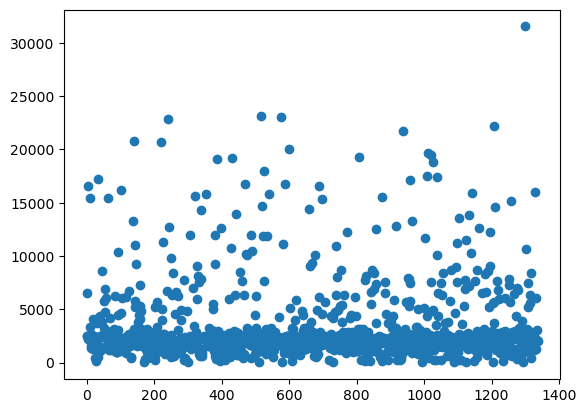

In [74]:
plt.scatter(X_train.index,y_residu)
plt.show()

Nous avons estimé que les valeurs résidues supérieures à 15000 proviennent de valeurs aberrantes présentent dans notre dataset.
Pour les supprimer nous cherchons d'abord les indices de ces valeurs résiduelles supérieures au seuil déterminé. 

In [75]:
indice_residu=y_residu[y_residu>15000].index
indice_residu

Int64Index([ 599,  140,  526, 1300, 1008,  430,  355,  321,  242, 1328,    3,
            1019, 1012,  696,   62,    9,  539, 1142,  876,  516,  468, 1258,
             959, 1027, 1206,  936,  102,  688,  587,  219,  577, 1039,   34,
             387,  806],
           dtype='int64')

Ensuite nous supprimons ces valeurs correspondantes dans y_residu (pour l'afficher dans un graph), X_train et y_train

In [76]:
y_residu_clean=y_residu.drop(indice_residu)


In [77]:
X_train_clean=X_train.drop(indice_residu)


In [78]:
y_train_clean=y_train.drop(indice_residu)

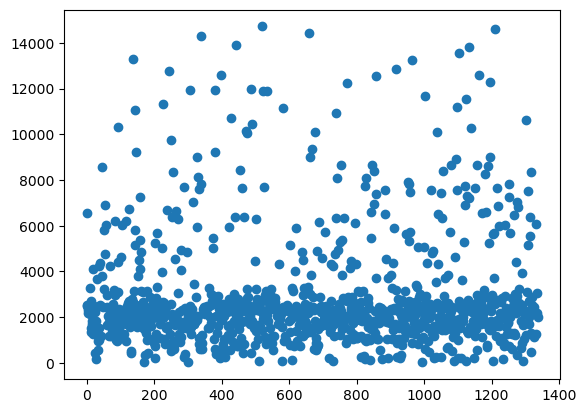

In [79]:
plt.scatter(X_train_clean.index,y_residu_clean)
plt.show()

In [80]:
df_clean= df.drop(indice_residu)

In [81]:
df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450


In [82]:
df.loc[indice_residu].smoker.value_counts()

no     31
yes     4
Name: smoker, dtype: int64

In [83]:
df.smoker.value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

Nous réentrainons notre model avec les nouvelles données

In [84]:
grid.fit(X_train_clean,y_train_clean)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('elasticnet',
                                        ElasticNet(alpha=25.125125125125127,
                                                   l1_ratio=0.9959919839679358,
                                                   random_state=42)...
       27.07070707, 27.17171717, 27.27272727, 27.37373737, 27.47474747,
       27.57575758, 27.67676768, 27.77777778, 27.87878788, 27.97979798,
       28.08080808, 28.18181818, 28.28282828, 28.38383838, 28.48484848,
       28.58585859, 28.68686869, 28.78787879, 28.88888889, 28.98989899,
       29.09090909, 29.19191919, 29.29292929, 29.39393939, 29.49494949,
       29.5959596 , 29.6969697 , 29.7979798 , 29.8989899 , 30.        ])},
             scoring='r2')

In [85]:
best_model_clean= grid.best_estimator_

In [86]:
best_model_clean.score(X_train_clean,y_train_clean)

0.8887581494567531

Notre ElasticNet ,en ayant supprimé ces valeurs atypiques influentes, s'ameliore!

#### Essayons de faire pareil avec la regression linéaire

In [87]:
# y_predict_lr=model_lr.predict(X_train)
# y_residu_lr=np.abs(y_predict_lr-y_train)
# plt.scatter(X_train.index,y_residu_lr)
# plt.show()

In [88]:
# indice_residu_lr=y_residu_lr[y_residu_lr>15000].index
# y_residu_lr_clean=y_residu_lr.drop(indice_residu_lr)
# X_train_clean_lr=X_train.drop(indice_residu_lr)
# y_train_clean_lr=y_train.drop(indice_residu_lr)

In [89]:
# cross_val=cross_validate(model_lr, X_train_clean_lr, y_train_clean_lr, cv=8)
# print(cross_val)
# cross_val['test_score'].mean()

Encore une fois la regression linéaire est plus performanate avec la regression lineaire

In [90]:
# model_lr.fit(X_train_clean_lr,y_train_clean_lr)
# model_lr.score(X_test,y_test)

In [91]:
X_cook= transformer.transform(df)
X_cook_columns= transformer.get_feature_names_out()

newdf= pd.DataFrame(X_cook)
newdf.columns = X_cook_columns
print(df)
newdf


      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1337 rows x 7 columns]


,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,robustscaler__age,robustscaler__bmi,robustscaler__children
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.833333,-0.278788,-0.5
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.875000,0.432727,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.458333,0.339394,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.250000,-0.908485,-0.5
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.291667,-0.160000,-0.5
...,...,...,...,...,...,...,...,...,...,...,...
1332,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.458333,0.093333,1.0
1333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.875000,0.208485,-0.5
1334,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.875000,0.806061,-0.5
1335,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.750000,-0.533333,-0.5


In [92]:
X_cook = newdf.loc[y_train.index]
X_cook.set_index(y_train.index,inplace=True)
X_cook

,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,robustscaler__age,robustscaler__bmi,robustscaler__children
1114,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.299394,0.0
968,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.499394,2.0
599,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.875000,1.086061,-0.5
170,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.366061,-0.5
275,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.333333,-0.436364,0.5
...,...,...,...,...,...,...,...,...,...,...,...
1096,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.708333,0.432727,-0.5
1131,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.750000,1.221818,-0.5
1295,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.875000,-0.493939,-0.5
861,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.666667,0.404242,0.5


In [93]:
model_c = OLS(y_train , X_cook).fit()
influence = model_c.get_influence().cooks_distance[0]
# print(influence)
cooks_distance = influence
print(cooks_distance)


[5.18551208e-04 8.35637409e-04 4.71588105e-03 ... 2.52945344e-04
 3.14678214e-04 8.28067503e-05]


In [94]:
analyse=X_train.copy()

In [95]:
analyse['dcooks'] = influence
n= X_train.shape[0]
p = X_train.shape[1]
seuil_dcook = 4/(n-p)

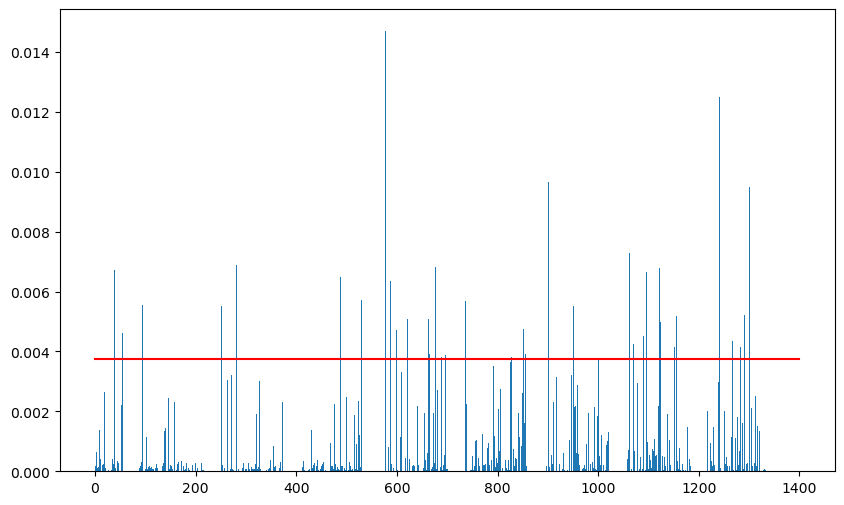

In [96]:
plt.figure(figsize=(10,6))
plt.bar(analyse.index, analyse['dcooks'])
# plt.xticks(np.arange(0, 200, step=1))
# plt.xlabel('Observation')
# plt.ylabel('Leviers')
plt.plot([0, 1400], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [97]:
residual_indice=analyse[analyse['dcooks']>seuil_dcook].index
residual_indice.size

65

In [98]:
analyse

,age,sex,bmi,children,smoker,region,dcooks
1114,23,male,24.510,0,no,northeast,0.000519
968,21,male,25.745,2,no,northeast,0.000836
599,52,female,37.525,2,no,northwest,0.004716
170,63,male,41.470,0,no,southeast,0.000005
275,47,female,26.600,2,no,northeast,0.000036
...,...,...,...,...,...,...,...
1096,51,female,34.960,2,yes,northeast,0.006640
1131,27,male,45.900,2,no,southwest,0.000975
1295,20,male,22.000,1,no,southwest,0.000253
861,38,female,28.000,3,no,southwest,0.000315


In [99]:
X_train.drop(residual_indice, inplace=True)



In [100]:
X_train.shape

(1004, 6)

In [101]:
y_train.drop(residual_indice, inplace=True)

In [102]:
model_lr = make_pipeline(transformer,PolynomialFeatures(2),LinearRegression())
cross_val=cross_validate(model_lr, X_train, y_train, cv=8)
print(cross_val)
cross_val['test_score'].mean()

{'fit_time': array([0.00933647, 0.00954914, 0.00792623, 0.00779462, 0.00896931,
       0.00770068, 0.00754166, 0.00758243]), 'score_time': array([0.00316095, 0.003335  , 0.00262833, 0.00269556, 0.00309062,
       0.00276113, 0.00256395, 0.00305367]), 'test_score': array([0.69545521, 0.71135834, 0.75530702, 0.66199791, 0.77806723,
       0.74723021, 0.79748503, 0.70733785])}


0.7317798482488207